In [1]:
import torch

torch.manual_seed(0)

import gpytorch
import botorch

import matplotlib.pyplot as plt

plt.style.use("bmh")

from tqdm.notebook import tqdm

import warnings

## 5.2 Being optimistic under uncertainty with the Upper Confidence Bound policy

In [2]:
def forrester_1d(x):
    # a modification of https://www.sfu.ca/~ssurjano/forretal08.html
    y = -((x + 1) ** 2) * torch.sin(2 * x + 2) / 5 + 1
    return y.squeeze(-1)


def visualize_gp_belief_and_policy(model, likelihood, policy=None, next_x=None):
    with torch.no_grad():
        predictive_distribution = likelihood(model(xs))
        predictive_mean = predictive_distribution.mean
        predictive_upper, predictive_lower = predictive_distribution.confidence_region()

        if policy is not None:
            acquisition_score = policy(xs.unsqueeze(1))

    if policy is None:
        plt.figure(figsize=(8, 3))

        plt.plot(xs, ys, label="objective", c="r")
        plt.scatter(train_x, train_y, marker="x", c="k", label="observations")

        plt.plot(xs, predictive_mean, label="mean")
        plt.fill_between(
            xs.flatten(), predictive_upper, predictive_lower, alpha=0.3, label="95% CI"
        )

        if next_x is not None:
            plt.axvline(next_x.item(), linestyle="dotted", c="k")

        plt.legend()
        plt.show()
    else:
        fig, ax = plt.subplots(
            2, 1, figsize=(8, 6), sharex=True, gridspec_kw={"height_ratios": [2, 1]}
        )

        # GP belief
        ax[0].plot(xs, ys, label="objective", c="r")
        ax[0].scatter(train_x, train_y, marker="x", c="k", label="observations")

        ax[0].plot(xs, predictive_mean, label="mean")
        ax[0].fill_between(
            xs.flatten(), predictive_upper, predictive_lower, alpha=0.3, label="95% CI"
        )

        if next_x is not None:
            ax[0].axvline(next_x.item(), linestyle="dotted", c="k")

        ax[0].legend()
        ax[0].set_ylabel("predictive")

        # acquisition score
        ax[1].plot(xs, acquisition_score, c="g")
        ax[1].fill_between(xs.flatten(), acquisition_score, 0, color="g", alpha=0.5)

        if next_x is not None:
            ax[1].axvline(next_x.item(), linestyle="dotted", c="k")

        ax[1].set_ylabel("acquisition score")

        plt.show()

In [3]:
class GPModel(gpytorch.models.ExactGP, botorch.models.gpytorch.GPyTorchModel):
    _num_outputs = 1

    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


def fit_gp_model(train_x, train_y, num_train_iters=500):
    # declare the GP
    noise = 1e-4

    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPModel(train_x, train_y, likelihood)
    model.likelihood.noise = noise

    # train the hyperparameter (the constant)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    model.train()
    likelihood.train()

    for i in tqdm(range(num_train_iters)):
        optimizer.zero_grad()

        output = model(train_x)
        loss = -mll(output, train_y)

        loss.backward()
        optimizer.step()

    model.eval()
    likelihood.eval()

    return model, likelihood

In [4]:
bound = 5

xs = torch.linspace(-bound, bound, bound * 100 + 1).unsqueeze(1)
ys = forrester_1d(xs)

torch.manual_seed(2)
train_x = torch.rand(size=(1, 1)) * 2 * bound - bound
train_y = forrester_1d(train_x)

In [5]:
train_x = torch.tensor([[1.0], [2.0]])
train_y = forrester_1d(train_x)

print(torch.hstack([train_x, train_y.unsqueeze(1)]))

tensor([[1.0000, 1.6054],
        [2.0000, 1.5029]])


### 5.2.3 Implementation with BoTorch

iteration 0
incumbent tensor([1.]) tensor(1.6054)


  0%|          | 0/500 [00:00<?, ?it/s]

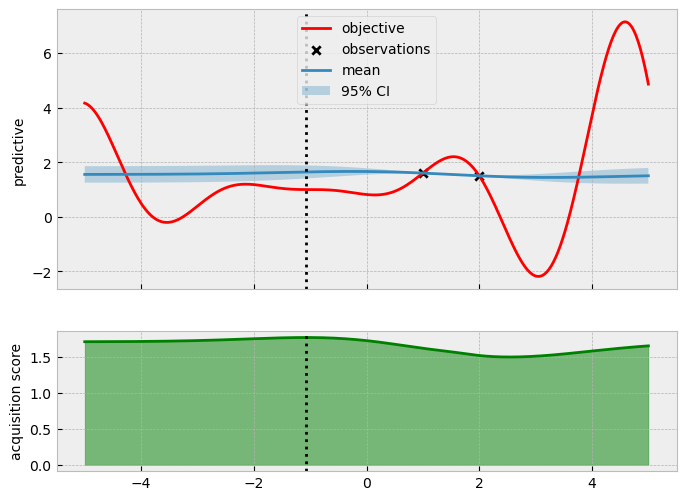

iteration 1
incumbent tensor([1.]) tensor(1.6054)


  0%|          | 0/500 [00:00<?, ?it/s]

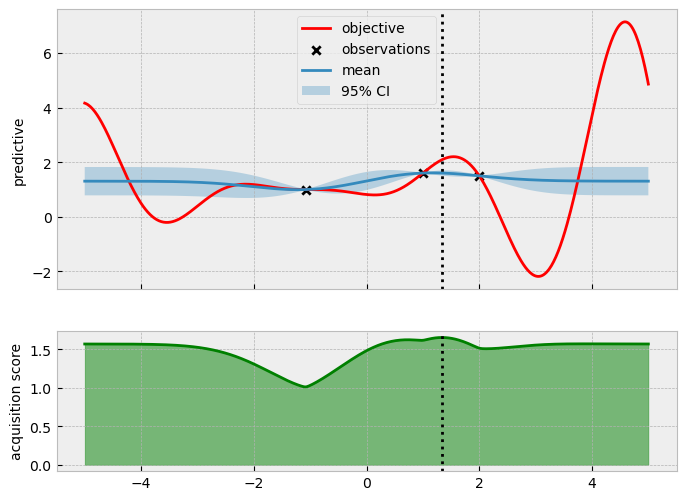

iteration 2
incumbent tensor([1.3373]) tensor(2.0918)


  0%|          | 0/500 [00:00<?, ?it/s]

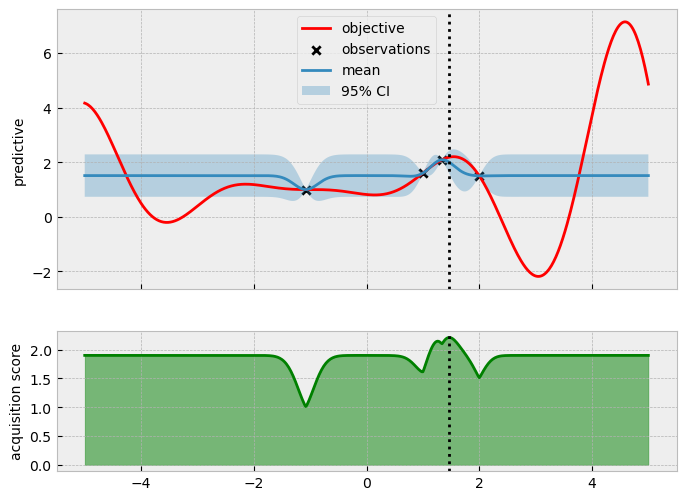

iteration 3
incumbent tensor([1.4681]) tensor(2.1879)


  0%|          | 0/500 [00:00<?, ?it/s]

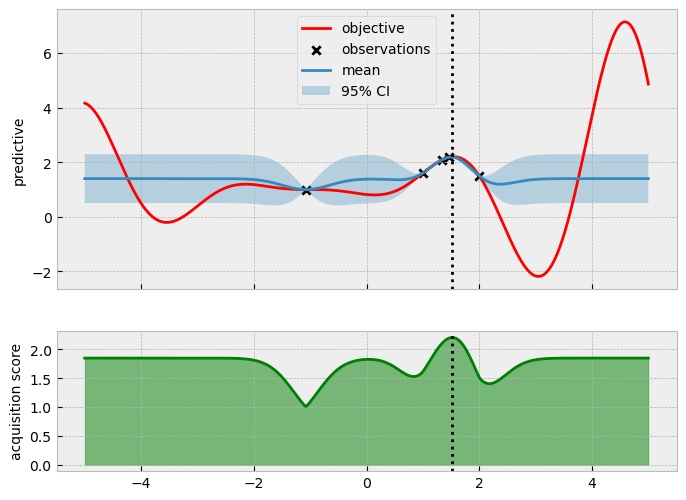

iteration 4
incumbent tensor([1.5214]) tensor(2.2027)


  0%|          | 0/500 [00:00<?, ?it/s]

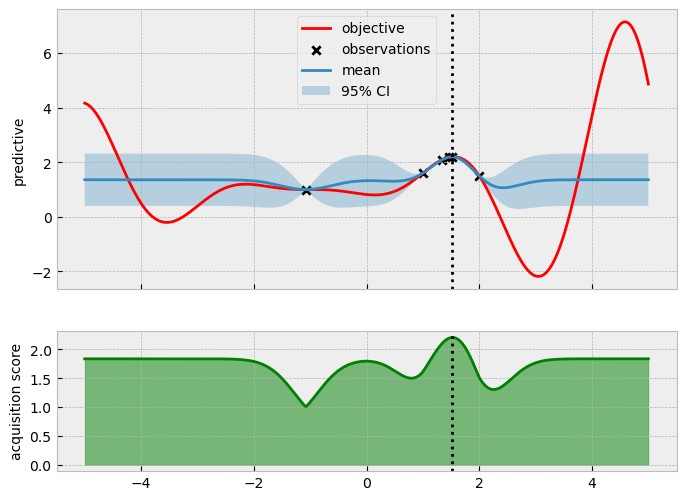

iteration 5
incumbent tensor([1.5249]) tensor(2.2031)


  0%|          | 0/500 [00:00<?, ?it/s]

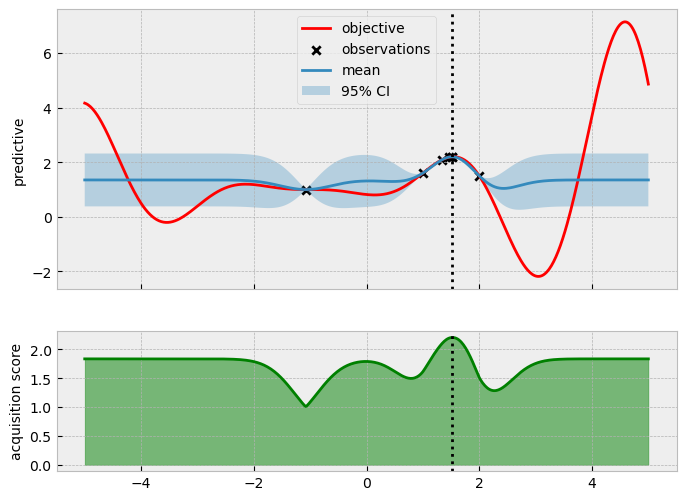

iteration 6
incumbent tensor([1.5249]) tensor(2.2031)


  0%|          | 0/500 [00:00<?, ?it/s]

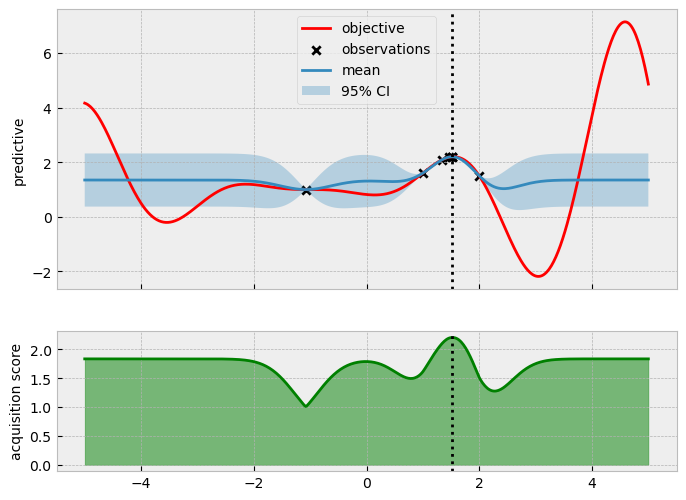

iteration 7
incumbent tensor([1.5249]) tensor(2.2031)


  0%|          | 0/500 [00:00<?, ?it/s]

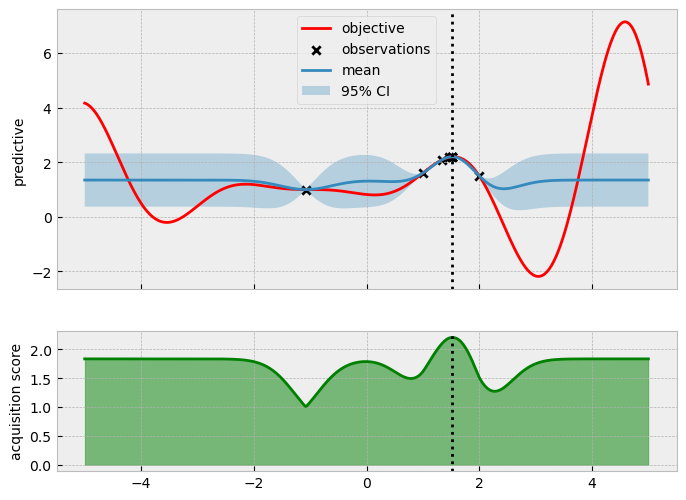

iteration 8
incumbent tensor([1.5249]) tensor(2.2031)


  0%|          | 0/500 [00:00<?, ?it/s]

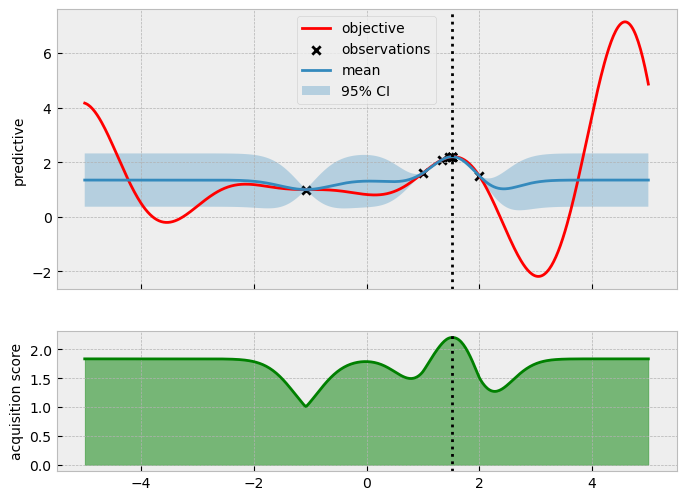

iteration 9
incumbent tensor([1.5249]) tensor(2.2031)


  0%|          | 0/500 [00:00<?, ?it/s]

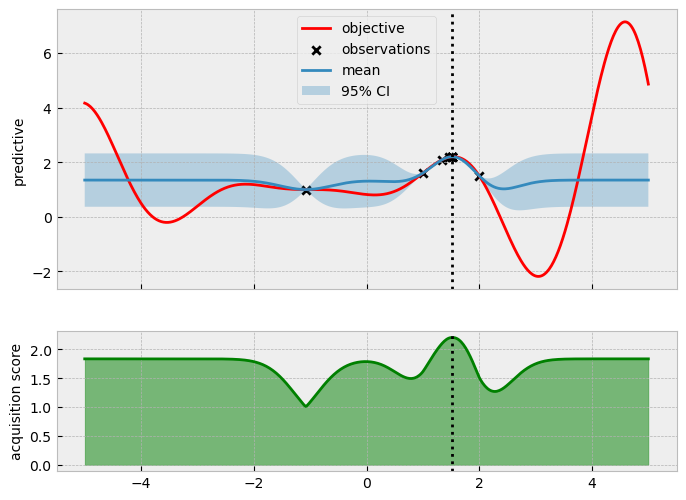

In [6]:
num_queries = 10

for i in range(num_queries):
    print("iteration", i)
    print("incumbent", train_x[train_y.argmax()], train_y.max())

    model, likelihood = fit_gp_model(train_x, train_y)

    policy = botorch.acquisition.analytic.UpperConfidenceBound(model, beta=1)
    
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=RuntimeWarning)
        
        next_x, acq_val = botorch.optim.optimize_acqf(
            policy,
            bounds=torch.tensor([[-bound * 1.0], [bound * 1.0]]),
            q=1,
            num_restarts=20,
            raw_samples=50,
        )

    visualize_gp_belief_and_policy(model, likelihood, policy, next_x=next_x)

    next_y = forrester_1d(next_x)

    train_x = torch.cat([train_x, next_x])
    train_y = torch.cat([train_y, next_y])

## 5.3 Smart sampling with the Thompson sampling policy

### 5.3.2 Implementation with BoTorch

iteration 0
incumbent tensor([1.]) tensor(1.6054)


  0%|          | 0/500 [00:00<?, ?it/s]

/Users/quannguyen/anaconda3/envs/gp_bo_new/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


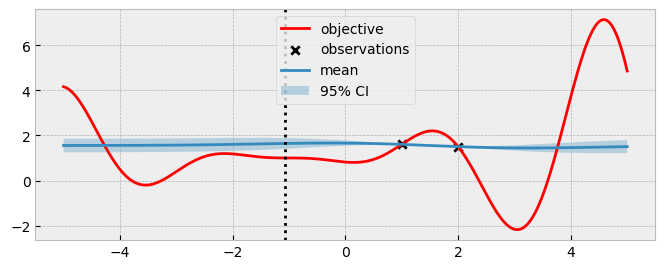

iteration 1
incumbent tensor([1.]) tensor(1.6054)


  0%|          | 0/500 [00:00<?, ?it/s]

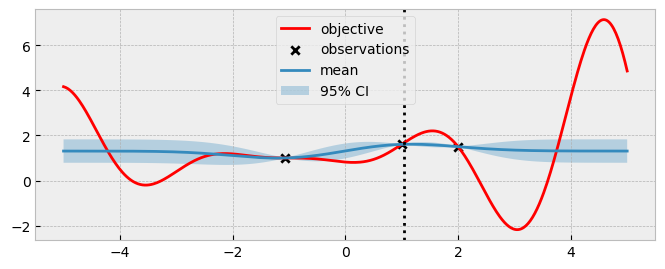

iteration 2
incumbent tensor([1.0475]) tensor(1.6837)


  0%|          | 0/500 [00:00<?, ?it/s]

/Users/quannguyen/anaconda3/envs/gp_bo_new/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/quannguyen/anaconda3/envs/gp_bo_new/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


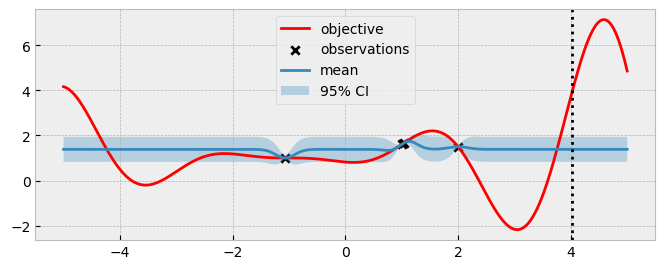

iteration 3
incumbent tensor([4.0214]) tensor(3.9215)


  0%|          | 0/500 [00:00<?, ?it/s]

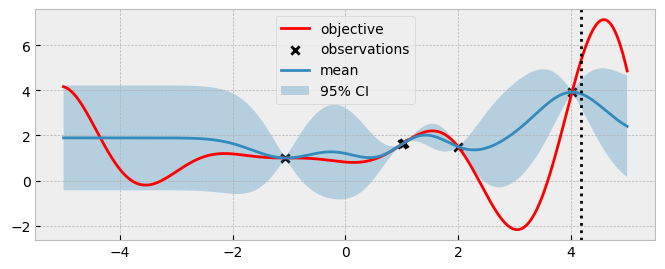

iteration 4
incumbent tensor([4.1770]) tensor(5.2943)


  0%|          | 0/500 [00:00<?, ?it/s]

/Users/quannguyen/anaconda3/envs/gp_bo_new/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-03 to the diagonal
  warnings.warn(


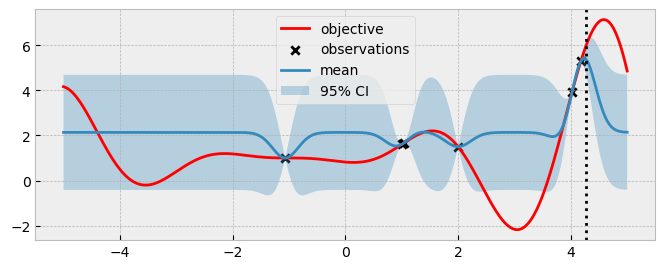

iteration 5
incumbent tensor([4.2630]) tensor(5.9401)


  0%|          | 0/500 [00:00<?, ?it/s]

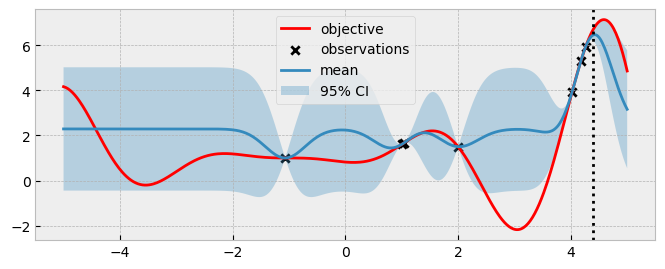

iteration 6
incumbent tensor([4.3881]) tensor(6.6670)


  0%|          | 0/500 [00:00<?, ?it/s]

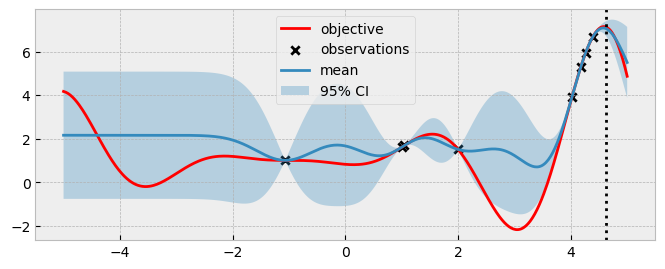

iteration 7
incumbent tensor([4.6180]) tensor(7.1308)


  0%|          | 0/500 [00:00<?, ?it/s]

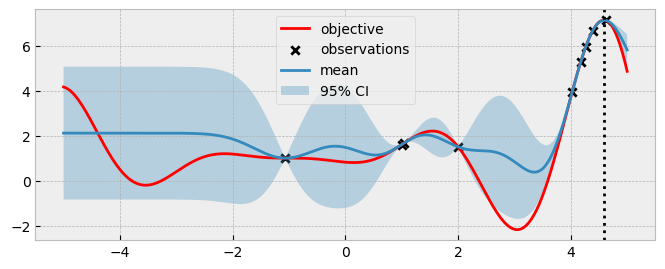

iteration 8
incumbent tensor([4.5843]) tensor(7.1438)


  0%|          | 0/500 [00:00<?, ?it/s]

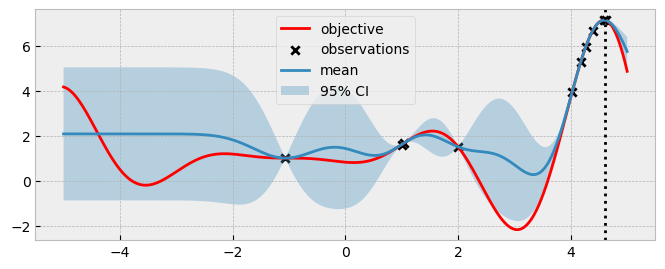

iteration 9
incumbent tensor([4.5843]) tensor(7.1438)


  0%|          | 0/500 [00:00<?, ?it/s]

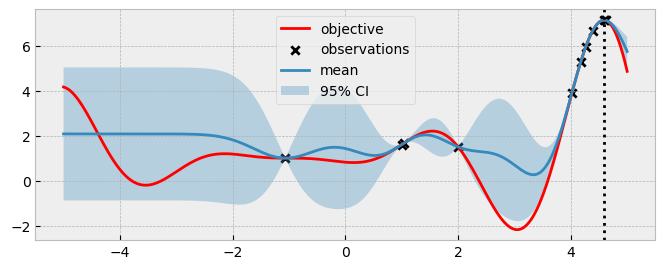

In [6]:
num_candidates = 1000
num_queries = 10

for i in range(num_queries):
    print("iteration", i)
    print("incumbent", train_x[train_y.argmax()], train_y.max())

    sobol = torch.quasirandom.SobolEngine(1, scramble=True)
    candidate_x = sobol.draw(num_candidates)
    candidate_x = 10 * candidate_x - 5

    model, likelihood = fit_gp_model(train_x, train_y)

    ts = botorch.generation.MaxPosteriorSampling(model, replacement=False)
    next_x = ts(candidate_x, num_samples=1)

    visualize_gp_belief_and_policy(model, likelihood, next_x=next_x)

    next_y = forrester_1d(next_x)

    train_x = torch.cat([train_x, next_x])
    train_y = torch.cat([train_y, next_y])